In [1]:
from __future__ import  division
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
from matplotlib.pylab import subplots
from matplotlib.patches import  Circle, Rectangle

* Statistical_Analysis_of_Failure_Time_Data_Sun.txt:21
* Applied_Survey_Data_Analysis_Heeringa.txt:29
* Applied_Survival_Analysis_Hosmer.txt:34

# Survival Curves

The problem is to estimate the length of time subjects (e.g., patients,
individuals, components) exist in a cohort over time. For example, consider the
following data. The rows are the days in a 7-day period and the columns are the
individual subjects. For example, these could be five patients who all receive a
particular treatment on day 0 and then *survive* (indicated by `1`) the next
seven days on not (indicated by `0`)

In [4]:
d = pd.DataFrame(index=range(1,8),columns=['A','B','C','D','E' ],data=1)
d.loc[3:,'A']=0
d.loc[6:,'B']=0
d.loc[5:,'C']=0
d.loc[4:,'D']=0
d.index.name='day'

In [5]:
d.T

day,1,2,3,4,5,6,7
A,1,1,0,0,0,0,0
B,1,1,1,1,1,0,0
C,1,1,1,1,0,0,0
D,1,1,1,0,0,0,0
E,1,1,1,1,1,1,1


Importantly, survival is a one-way street --- once a subject is *dead*, then
that subject cannot return to the experiment. This is important because survival
analysis is also applied to component-failure or other topics where this fact is
not so obvious. The following chart shows the survival status of each of the
subjects for all seven days. The blue circles indicate that the subject is alive
and the red squares indicate death of the subject.

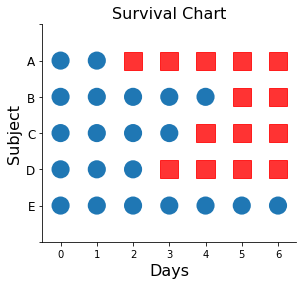

In [6]:
fig,ax =subplots()

ax.axis((-0.5,6.5,-1,5))

for ii,jj in zip(*np.where(d.values)):
    ax.add_patch(Circle((ii,jj),0.25))

for ii,jj in zip(*np.where(d.values==0)):
    ax.add_patch(Rectangle((ii-0.25,jj-0.25),0.5,0.5,color='red',alpha=.8))
    
ax.set_yticklabels(['','A','B','C','D','E','',''],fontsize=12);
ax.invert_yaxis()
ax.set_xlabel('Days',fontsize=16)
ax.set_ylabel('Subject',fontsize=16)
ax.set_title('Survival Chart',fontsize=16)

ax.spines['right'].set_visible(0)
ax.spines['top'].set_visible(0)
ax.set_aspect(1)

Given this chart, we can estimate the probability of survival ($\mathbb{P}_S$).
At $t=0$, all subjects live. Thus, the probability of survival,
$\mathbb{P}_S(t=0)=1$. This is the same for $t=1$, so we say that
$\mathbb{P}_S(t\ge 1) = 1$; in words, the probability of surviving past day
one is one. Equivalently, the probability of having a death up until and
including day one is zero $\left(\mathbb{P}(t\le 1)=0\right)$. 

On day two,
subject **A** dies and there are now four out of the five subjects remaining in
the study. Then, $\mathbb{P}_S(t\ge 2) = 4/5$. 
On the third day, subject **D** dies, so now there are three out of the five original subjects remaining and
$\mathbb{P}_S(t\ge 3) = 3/5$. Similarly, **C** dies on day 4 ($\mathbb{P}_S(t\ge 4) = 2/5$) and **B** dies on day five
($\mathbb{P}_S(t\ge 5) = 1/5$). Subject **E** survives until the end ($\mathbb{P}_S(t\ge 6) = 1/5$). Putting all this together gives the following survival curve.

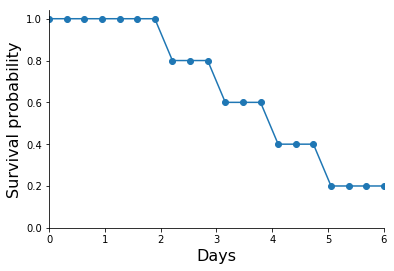

In [7]:
fig,ax=subplots()
x = pd.Series(index = np.linspace(0,6,20),data=5)
x[np.logical_and(x.index>=1,x.index<=2)]=5
x[np.logical_and(x.index>=2,x.index<=3)]=4
x[np.logical_and(x.index>=3,x.index<=4)]=3
x[np.logical_and(x.index>4,x.index<=5)]=2
x[np.logical_and(x.index>5,x.index<=6)]=1
(x/5.).plot(ax=ax,marker='o')
ax.set_xlabel("Days",fontsize=16)
ax.set_ylabel("Survival probability",fontsize=16)
ax.axis(ymin=0)
ax.spines['right'].set_visible(0)
ax.spines['top'].set_visible(0)

There is another important recursive perspective on this calculation. Imagine
there is a life raft containing $[A,B,C,D,E]$. Everyone survives until day two
when **A** dies. This leaves four in the life raft $[B,C,D,E]$. Thus,  from the
perspective of day one, the survival probability is the probability of surviving
just up until day two and then surviving day two, $\mathbb{P}_S(t\ge 2)
=\mathbb{P}(t\notin [0,2)\vert t<2)\mathbb{P}_S(t=2)=(1)(4/5)=4/5$. In words,
this means that surviving past the second day is the product of surviving the
second day itself and not having a death up to that point (i.e., surviving up to
that point). Using this recursive approach, the survival probability for the
third day is $\mathbb{P}_S(t\ge 3) =\mathbb{P}_S(t \gt
3)\mathbb{P}_S(t=3)=(4/5)(3/4)=3/5$. Recall that just before the third day, the
life raft contains $[B,C,D,E]$ and  on the third day we have $[B,C,E]$. Thus,
from the perspective of just before the third day there are four survivors in
the raft and on the third day there are three $3/4$. Using this recursive
argument generates the same plot and comes in handy with censoring.

## Censoring and Truncation

Censoring occurs when a subject leaves (right censoring) or enters (left
censoring) the study. There are two general types of right censoring. The so-
called Type I right censoring is when a subject randomly drops out of the study.
This random drop-out is another statistical effect that has to be accounted for
in estimating survival. Type II right censoring occurs when the study is
terminated when enough specific random events occur (i.e., some threshold is
reached).


Likewise, left censoring occurs when a subject enters the study
prior to a certain date, but exactly when this happened is unknown. This happens
in study designs involving two separate studies stages. For example, a subject
might enroll in the first selection process but be ineligible for the second
process. Specifically, suppose a study concerns drug use and certain subjects
have used the drug before the study but are unable to report exactly when. These
subjects are left censored. Left truncation (a.k.a. staggered entry, delayed
entry) is similar except the date of entry is known. For example, a subject that
starts taking a drug after being initially left out of the study.

Right
censoring is the most common so let's consider an example. Let's estimate the
survival function given the following survival times in days:

$$ \{ 1,
2,3^+,4,5,6^+,7,8 \}$$

where the censored survival times are indicated by the
plus symbol. As before, the survival time at the $0^{th}$ day is $8/8=1$, the
first day is $7/8$, the second day = $(7/8)(6/7)$. Now, we come to the first
right censored entry. The survival time for the third day is $(7/8)(6/7)(5/5) =
(7/8)(6/7)$. Thus, the subject who dropped out is not considered *dead* and
cannot be counted as such but is considered just *absent* as far as the
functional estimation of the probabilities goes. Continuing for the fourth day,
we have $(7/8)(6/7)(5/5)(4/5)$, the fifth day, $(7/8)(6/7)(5/5)(4/5)(3/4)$, the
sixth (right censored) day $(7/8)(6/7)(5/5)(4/5)(3/4)(2/2)$, and so on. We can
summarize this in the following table:

| day  | survival|
|:------|--------:|
|
0  | 1     |
|   1  | $7/8$ |
|   2  | $3/4$ |
|   3$^+$  | $3/4$ |
|   4  |
$3/5$ |
|   5  | $9/20$|
|   6$^+$  | $9/20$|
|   7  | $9/40$|
|   8  | 0     |


## Hazard Functions and Their Properties

Generally, the **survival function** is a continuous function of time $S(t) =
\mathbb{P}(T>t)$ where $T$ is the event time (e.g., time of death). Note that
the cumulative density function, $F(t)=\mathbb{P}(T\le t)=1-S(t)$ and
$f(t)=\frac{dF(t)}{dt}$ is the usual probability density function. The so-called
**hazard function** is the instantaneous rate of failure at time $t$,

$$ h(t) =
\frac{f(t)}{S(t)} = \lim_{\Delta t \rightarrow 0}\frac{\mathbb{P}(T \in
(t,t+\Delta t]|T\ge t)}{\Delta t}$$

Note that is a continuous-limit version of
the calculation we performed above. In words, it says given the event time $T\ge
t$ (subject has survived up to $t$), what is the probability of the event
occurring in the differential interval $\Delta t$ for a vanishingly small
$\Delta t$. Note that this is not the usual derivative-slope from calculus
because there is no difference term in the numerator. The hazard function is
also called the **force of mortality**, **intensity rate**, or the
**instantaneous risk**. Informally, you can think of the hazard function as
encapsulating the two issues we are most concerned about: deaths and the
population at risk for those deaths. Loosely speaking, the probability density
function in the numerator represents the probability of a death occurring in a
small differential interval. However, we are not particularly interested in
unqualified deaths, but only deaths that can happen to a specific at-risk
population. Returning to our lifeboat analogy, suppose there are 1000 people in
the lifeboat and the probability of anybody falling off the lifeboat is 1/1000.
Two things are happening here: (1) the probability of the bad event is small and
(2) there are a lot of subjects over which to spread the probability of that bad
event. This means that the hazard rate for any particular individual is small.
On the other hand, if there are only two subjects in the life raft and the
probability of falling off is 3/4, then the hazard rate is high because not only
is the unfortunate event probable, the risk of that unfortunate event is shared
by only two  subjects.

It is a mathematical fact that,

$$ h(t) = \frac{-d \log
S(t)}{dt}$$

This leads to the following interpretation

$$ S(t) = \exp\left(
-\int_0^t h(u)du\right) := \exp(-H(t))$$

where $H(t)$ is the **cumulative
hazard function**. Note that $H(t)=-\log S(t)$. Consider a subject  whose
survival time is 5 years. For this subject to have died at the fifth year, it had
to be alive during the fourth year. Thus, the *hazard* at five years  is the
failure rate per-year, conditioned on the fact that the subject  survived until
the fourth year. Note that this is *not* the same as the unconditional failure
rate per year at the fifth year, because the unconditional rate applies to all
subjects  at time zero and does not use information about survival up to that
point gleaned from the other subjects. Thus, the *hazard function* can be
thought of as the point-wise unconditional probability of experiencing the
event, scaled by the fraction of survivors up to that point.

#### Example

To
get a sense of this, let's consider the example where the probability density
function  is exponential with parameter $\lambda$, $f(t)=\lambda
\exp(-t\lambda),\; \forall t>0$. This makes $S(t) = 1- F(t) = \exp(-t\lambda)$
and then the hazard function becomes $h(t)=\lambda$, namely a constant. To see
this, recall that the exponential distribution is the only continuous
distribution that has no memory:

$$ \mathbb{P}(X\le u+t \vert X>u) =
1-\exp(-\lambda t) = \mathbb{P}(X\le t)$$

This means no matter how long we have
been waiting for a death to occur, the probability of a death from that point
onward is the same -- thus the hazard function is a constant.

### Expectations

Given all these definitions, it is an exercise in integration
by parts to show that the expected life remaining is the following:

$$
\mathbb{E}(T) = \int_0^\infty S(u) du $$

This is equivalent to the following:
$$ \mathbb{E}(T \big\vert t=0) = \int_0^\infty S(u) du $$

and we can likewise
express the expected remaining life at $t$ as the following,

$$ \mathbb{E}(T
\big\vert T\ge t) = \frac{\int_t^\infty S(u) du}{S(t)} $$

## Parametric regression models

Because we are interested in how study parameters affect survival, we need a
model that can accommodate regression in exogenous variables ($\mathbf{x}$).

$$
h(t\vert \mathbf{x})= h_o(t)\exp(\mathbf{x}^T \mathbf{\boldsymbol{\beta}}) $$
where $\boldsymbol{\beta}$ are the regression coefficients and $h_o(t)$ is the
baseline instantaneous hazard function. Because the hazard function is always
nonnegative, the the effects of the covariates enter through the exponential
function. These kinds of models are called **proportional hazard rate models**.
If the baseline function is a constant ($\lambda$), then this reduces to the
**exponential regression model** given by the following:

$$ h(t\vert
\mathbf{x}) = \lambda  \exp(\mathbf{x}^T \mathbf{\boldsymbol{\beta}}) $$

### Cox proportional hazards model

The tricky part about the above proportional
hazard rate model is the specification of the baseline instantaneous hazard
function. In many cases, we are not so interested in the absolute hazard
function (or its correctness), but rather a comparison of such hazard functions
between two study populations. The Cox model emphasizes this comparison by using
a maximum likelihood algorithm for a partial likelihood function. There is a lot
to keep track of in this model, so let's try the mechanics  first to get a feel
for what is going on.

Let $j$ denote the $j^{th}$ failure time, assuming that
failure times are sorted in increasing order. The hazard function for subject $i$
at failure time $j$ is $h_i(t_j)$. Using the general proportional hazards model,
we have

$$ h_i(t_j) = h_0(t_j)\exp(z_i \beta) := h_0(t_j)\psi_i$$

To keep it
simple, we have $z_i \in \{0,1\}$ that indicates membership in the experimental
group ($z_{i}=1$) or the control group ($z_i=0$).

Consider the first failure
time, $t_1$ for subject $i$ failing is the hazard function
$h_i(t_1)=h_0(t_1)\psi_{i}$. From the definitions, the probability that subject $i$
is the one who fails is the following:

$$ p_1 = \frac{h_{i}(t_1)}{\sum
h_k(t_1)}= \frac{h_{0}(t_1)\psi_i}{\sum h_0(t_1) \psi_k}$$

where the summation
is over all surviving subjects up to that point. Note that the baseline hazard
cancels out and gives the following,

$$ p_1=\frac{\psi_{i}}{\sum_k \psi_k} $$
We can keep computing this for the other failure times to obtain
$\{p_1,p_2,\ldots\,p_D\}$. The product of all of these is the **partial
likelihood**, $L(\psi) = p_1\cdot p_2\cdots p_D$. The next step is to maximize
this partial likelihood (usually logarithm of the partial likelihood) over
$\beta$. There are a lot of numerical issues to keep track of here. Fortunately,
the Python [lifelines](https://lifelines.readthedocs.io/en/latest/index.html)
module can keep this all straight for us.

Let's see how this works using the
`Rossi` dataset that is available in lifelines.

In [8]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter, KaplanMeierFitter
rossi_dataset = load_rossi()

The Rossi dataset dataset concerns prison recidivism. [Full documentation
here](http://socserv.socsci.mcmaster.ca/jfox/Books/Companion/appendix/Appendix-
Cox-Regression.pdf). The `fin` variable indicates whether or not the subjects
received financial assistance upon discharge from prison. 

* `week`: week of
first arrest after release, or censoring time.
* `arrest`: the event indicator,
equal to 1 for those arrested during the period of the study and 0 for those who
were not arrested.
* `fin`: a factor, with levels yes if the individual received
financial aid after release from prison, and no if he did not; financial aid was
a randomly assigned factor manipulated by the researchers.
* `age`: in years at
the time of release.  
* `race`: a factor with levels black and other.
* `wexp`:
a factor with levels yes if the individual had full-time work experience prior
to incarceration and no if he did not.
* `mar`: a factor with levels married if
the individual was married at the time of release and not married if he was not.
* `paro`: a factor coded yes if the individual was released on parole and no if
he was not.
* `prio`: number of prior convictions.
* `educ`: education, a
categorical variable coded numerically, with codes 2 (grade 6 or less), 3
(grades 6 through 9), 4 (grades 10 and 11), 5 (grade 12), or 6 (some post-
secondary).6
* `emp1` -- `emp52`: factors coded yes if the individual was
employed in the corresponding week of the study and no otherwise.

In [9]:
rossi_dataset.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


Now, we just have to set up the calculation in `lifelines`, using the `scikit-
learn` style. The `lifelines` module handles the censoring issues.

In [10]:
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')
cph.print_summary()  # access the results using cph.summary

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-02-19 17:33:23 UTC

---
      coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
fin  -0.38       0.68      0.19 -1.98   0.05      4.40       -0.75       -0.00
age  -0.06       0.94      0.02 -2.61   0.01      6.79       -0.10       -0.01
race  0.31       1.37      0.31  1.02   0.31      1.70       -0.29        0.92
wexp -0.15       0.86      0.21 -0.71   0.48      1.06       -0.57        0.27
mar  -0.43       0.65      0.38 -1.14   0.26      1.97       -1.18        0.31
paro -0.08       0.92      0.20 -0.43   0.66      0.59       -0.47        0.30
prio  0.09       1.10      0.03  3.19 <0.005      9.48        0.04        0.15
---
Concordance = 0.64
Likelihood ratio test = 33.27 on 7 df, -log2(p)=15.37


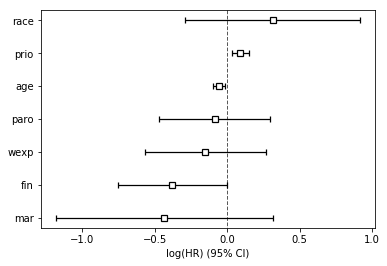

In [11]:
ax=cph.plot();

In [15]:
rossi_dataset.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [12]:
kmf1 = KaplanMeierFitter()
t1 = rossi_dataset[rossi_dataset.fin==1] 
kmf1.fit(t1.week,event_observed=t1.arrest,label='fin=1')
kmf0 = KaplanMeierFitter()
t0 = rossi_dataset[rossi_dataset.fin==0] 
kmf0.fit(t0.week,event_observed=t0.arrest,label='fin=0')

<lifelines.KaplanMeierFitter: fitted with 216 observations, 150 censored>

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


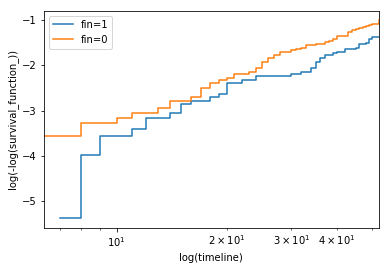

In [13]:
fig, ax = subplots()
kmf1.plot_loglogs(ax=ax)
kmf0.plot_loglogs(ax=ax)

Text(0.5, 0, 'weeks')

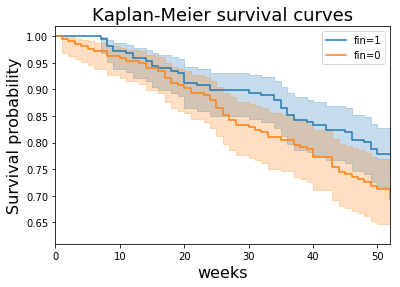

In [42]:
fig, ax = subplots()
kmf1.plot_survival_function(ax=ax)
kmf0.plot_survival_function(ax=ax)
ax.set_title('Kaplan-Meier survival curves',fontsize=18)
ax.set_ylabel('Survival probability',fontsize=16)
ax.set_xlabel('weeks',fontsize=16)

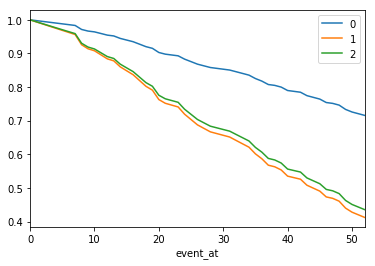

In [53]:
fig,ax=subplots()
cph.predict_survival_function(rossi_dataset.iloc[:3,:]).plot(ax=ax)